# Onset detection
## Musical Onsets

The notion of a musical onset can be rather vague and is related to other concepts such as attacks or transients. When playing a note on an instrument such as a piano, there is often a sudden increase of energy at the beginning of a musical tone. The **attack** of a note refers to the phase where the sound builds up, which typically goes along with a sharply increasing amplitude envelope. The related concept of a **transient** refers to a noise-like sound component of short duration and high amplitude typically occurring at the beginning of a musical tone or a more general sound event. As opposed to the attack and transient, the **onset** of a note refers to the single instant (rather than a period) that marks the beginning of the transient, or the earliest time point at which the transient can be reliably detected. This is illustrated by the following figure.

<img src="img/otad.png" width="320px" align="middle" alt="Attack, transient, decay and onset for a single note">

Intuitively speaking, **onset detection** is the task of determining the starting times of notes or other musical events as they occur in a music recording. To detect note onsets in the signal, the general idea is to capture sudden changes that often mark the beginning of transient regions. For notes that have a pronounced attack phase, onset candidates may be determined by locating time positions where the signal's amplitude envelope starts increasing. In the following figure, we show the waveform and the spectrogram of a click sound as well as of a piano sound (playing the note $\mathrm{C4}$):

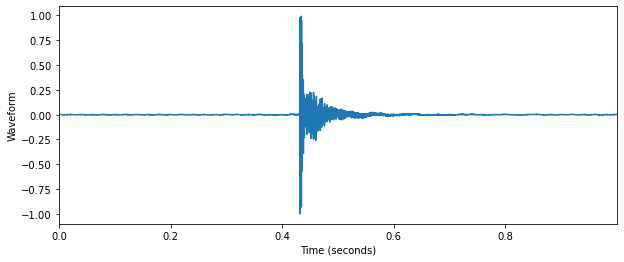

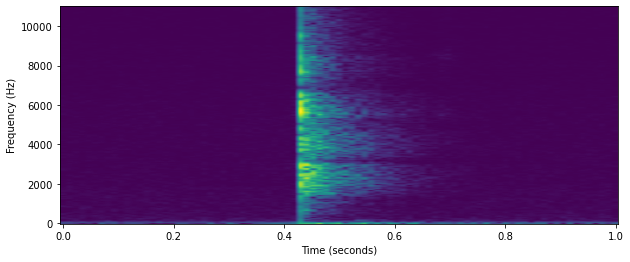

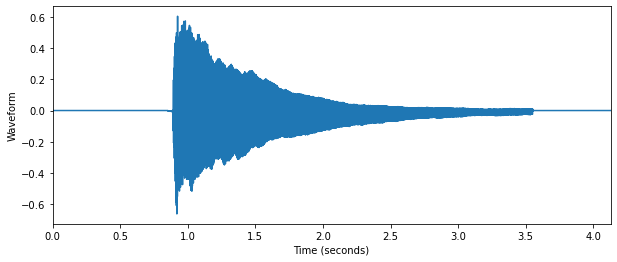

In [2]:
import os, sys
import sys
import numpy as np
from scipy import signal
# we need to install matplotlib with conda
from  matplotlib import pyplot as plt
import librosa
import IPython.display as ipd

def load_and_plot_wav(fn_wav, display_audio=True):
    x, Fs = librosa.load(fn_wav, sr=None) 
    plt.figure(figsize=(10,4))
     
    time_axis = np.arange(x.shape[0]) / Fs
    plt.plot(time_axis, x)
    plt.xlim([time_axis[0], time_axis[-1]])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Waveform')
    if display_audio == True:
        ipd.display(ipd.Audio(x, rate=Fs))
    return x, Fs



def plot_spectrogram(x, Fs):
    N, H = 512, 256 
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Y = np.log(1 + 10 * np.abs(X))
    
    time_axis = np.arange(X.shape[1]) / (Fs / H)
    frequency_axis = np.arange(X.shape[0]) / (N / Fs)
    
    x_ext = (time_axis[1] - time_axis[0]) / 2
    y_ext = (frequency_axis[1] - frequency_axis[0]) / 2
    image_extent = [time_axis[0]-x_ext, time_axis[-1]+x_ext, frequency_axis[0]-y_ext, frequency_axis[-1]-y_ext]
    
    plt.figure(figsize=(10,4))
    plt.imshow(Y, extent=image_extent, aspect='auto', origin='lower')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency (Hz)')
    
fn_wav = os.path.join('audio', 'Impulse.wav')
x, Fs = load_and_plot_wav(fn_wav)
plot_spectrogram(x, Fs)

fn_wav = os.path.join('audio', 'NoteC4_Piano.wav')
x, Fs = load_and_plot_wav(fn_wav)
plot_spectrogram(x, Fs)

When there is no clear attack phase, such as for nonpercussive music with soft onsets and blurred note transitions, the detection of onsets is much more challenging. For example, the waveform of a violin sound may exhibit a slow energy increase rather than an abrupt change as in a piano sound. For soft sounds, it is hard to determine or even to define the exact onset position. This is illustrated by the violin example (sound of $\mathrm{C4}$) of the next figure:

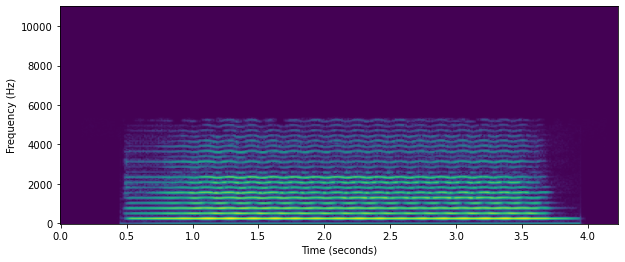

In [3]:
fn_wav = os.path.join('audio', 'NoteC4_Violin.wav')
x, Fs = load_and_plot_wav(fn_wav)
plot_spectrogram(x, Fs)

The detection of individual note onsets becomes even harder when dealing with complex polyphonic music. Simultaneously occurring sound events may result in masking effects, where no significant changes in the signal's energy are measurable.




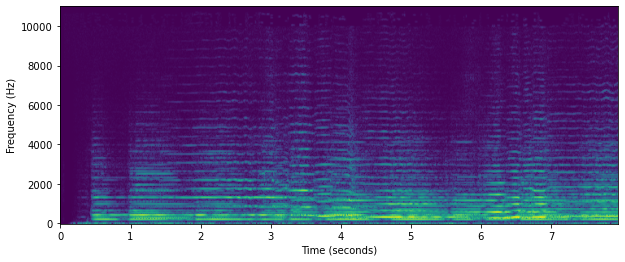

In [4]:
fn_wav = os.path.join('audio', 'Audio_Borodin-sec39_RWC.wav')
x, Fs = load_and_plot_wav(fn_wav)
plot_spectrogram(x, Fs)



## General Pipeline

Many approaches for onset detection follow a similar algorithmic pipeline, but differ in the signal properties that are exploited to derive onset candidates. In this pipeline, the main steps are as follows:

* First, the signal is converted into a suitable feature representation that better reflects the properties of interest. 
* Then, a type of derivative operator is applied to the feature sequence and a **novelty function** is derived. 
* Finally, a peak-picking algorithm is employed to locate the onset candidates.


<img src="img/onsetdetection_pipeline.png"  width="500" align="middle" alt="Onset detection architecture">



In particular, we show how to transform a given music signal into a **novelty representation** that captures certain changes in the signal's energy or spectrum. The peaks of such a representation yield good indicators for note onset candidates. We will see a similar concept when applying novelty detection to music structure analysis. 

There are four different approaches for computing novelty functions:

* **Energy-based novelty** approaches measure changes in the flow of the signal's local energy

* **Spectral-based novelty** approaches measure changes of the signal's spectral content over time.

* **Phase-based novelty** approaches measure indicate discontinuities in the signal's phase spectrum.

* **Complex-domain novelty** approaches combine spectral-based and phase-based information.


## Example: Another One Bites the Dust
  
As an illustrative example, we consider an excerpt of "Another one bites the dust" by Queen. Starting with an offbeat consisting of two sixteenth notes played only by bass, four percussive beats (played by kick drum, snare drum, hihat, and bass) follow. Furthermore, between each two subsequent beats, there is an additional hihat stroke. The subsequent figure shows the waveform with annotated onset positions. 

<img src="img/Queen.png" width="350px" align="left" alt="Queen">

<br clear="all" />

<audio style="width: 320px;" src="audio/Queen.wav" type="audio/mpeg" controls="controls"></audio>

The following spectrogram representation shows, that the quarter-note drum beats as well as the hihat sounds go along with transients (vertical lines), while the initial two bass-only sounds have more diffuse onset properties.

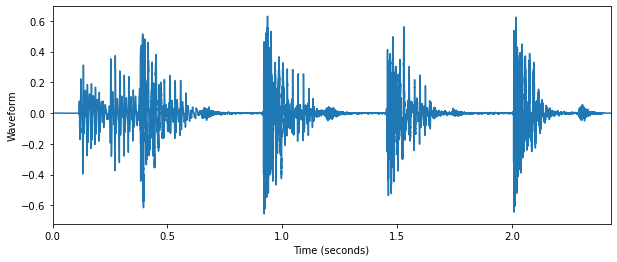

In [7]:
fn_wav = os.path.join('audio', 'Queen.wav')

x, Fs = load_and_plot_wav(fn_wav)
plot_spectrogram(x, Fs)

In the next code cell, we use a spectral-based method for computing a novelty function. 



In [8]:
def compute_local_average(x, M, Fs=1):
    """Compute local average of signal

    Args:
        x: Signal
        M: Determines size (2M+1*Fs) of local average
        Fs: Sampling rate

    Returns:
        local_average: Local average signal
    """
    L = len(x)
    M = int(np.ceil(M * Fs))
    local_average = np.zeros(L)
    for m in range(L):
        a = max(m - M, 0)
        b = min(m + M + 1, L)
        local_average[m] = (1 / (2 * M + 1)) * np.sum(x[a:b])
    return local_average


def a_method_for_novelty(x, Fs=1, N=1024, H=256, gamma=100, M=10, norm=1):
    """Compute spectral-based novelty function
    """
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Fs_feature = Fs / H
    Y = np.log(1 + gamma * np.abs(X))
    Y_diff = np.diff(Y)
    Y_diff[Y_diff < 0] = 0
    novelty_spectrum = np.sum(Y_diff, axis=0)
    novelty_spectrum = np.concatenate((novelty_spectrum, np.array([0.0])))
    if M > 0:
        local_average = compute_local_average(novelty_spectrum, M)
        novelty_spectrum = novelty_spectrum - local_average
        novelty_spectrum[novelty_spectrum < 0] = 0.0
    if norm == 1:
        max_value = max(novelty_spectrum)
        if max_value > 0:
            novelty_spectrum = novelty_spectrum / max_value
    return novelty_spectrum, Fs_feature



In [9]:
onsets = [0.117460317, 0.247619048, 0.646349206, 1.184761905, 1.735238095, 2.287619048]
beats = [0.372698413, 0.911111111, 1.445442177,  2.000000000]

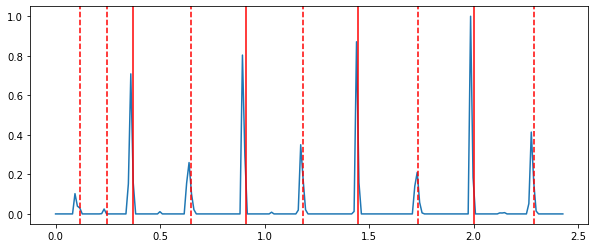

In [11]:
fn_wav = os.path.join('audio', 'Queen.wav')
x, Fs = librosa.load(fn_wav)

nov, Fs_nov =a_method_for_novelty(x, Fs=Fs)

plt.figure(figsize=(10, 4))
nov_time_axis = np.arange(nov.shape[0]) / Fs_nov
plt.plot(nov_time_axis, nov)


for b in beats:
    plt.axvline(b, color='red')
    
for o in onsets:
    plt.axvline(o, color='red', linestyle='--')

Finally, we apply a peak picking strategy to locate the **local maxima** or **peaks** of the novelty function. The positions of the peaks are our candidates for onset positions. In the following code, cell we apply a peak picking strategy provided by the function [`scipy.signal.find_peaks`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html). In the following cell, we generate a visualization of the peaks along with a **sonification** via a click track added to the original audio recording. 

In [14]:
peaks, properties = signal.find_peaks(nov, prominence=0.2)
peaks_sec = nov_time_axis[peaks]

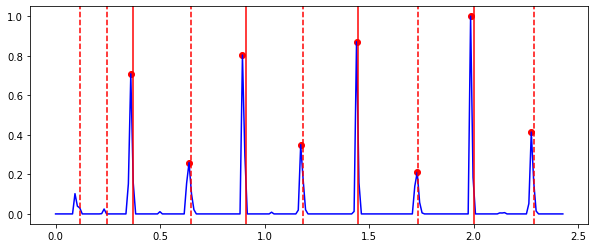

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(nov_time_axis, nov, color='blue')

for b in beats:
    plt.axvline(b, color='red')
    
for o in onsets:
    plt.axvline(o, color='red', linestyle='--')
    
plt.scatter(peaks_sec, nov[peaks], marker='o', color='red' )

In [20]:
x_peaks = librosa.clicks(peaks_sec, sr=Fs, click_freq=1000, 
                         length=len(x))
ipd.display(ipd.Audio( x + 0.5*x_peaks, rate=Fs))

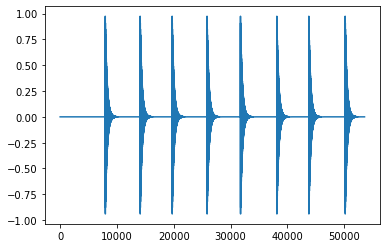